# Lab05: Spike‑Timing‑Dependent Plasticity (STDP)
Welcome to the hands‑on lab for exploring STDP!  
In this notebook you will:
1. Implement the Song–Abbott–Miller leaky integrate‑and‑fire (LIF) neuron model with pair‑based STDP.  
2. Generate several kinds of presynaptic spike trains.  
3. Run three guided experiments and interpret the results.

## Neuron and synapse model
We follow the parameters reported by **Song et al. 2000** for their current‑based LIF neuron [τ_m = 20 ms, V_rest = −70 mV, V_th = −54 mV, V_reset = −60 mV, τ_ex = τ_in = 5 ms, g_max = 0.015 (dimensionless)].  Weights are bounded in **[0, g_max]** and updated with the classical pair‑based STDP rule:
$$\Delta g = \begin{cases}
A_+\,e^{\Delta t/\tau_+} & \Delta t<0\\[2pt]
-A_-\,e^{-\Delta t/\tau_-} & \Delta t\ge0\end{cases}$$
with $\tau_+=\tau_-\;{=}$ 20 ms, $A_+=0.005\,g_{\max}$ and $A_-/A_+=1.05$.

## Learning goals
After completing the notebook you should be able to:
* Explain how the relative timing of pre‑ and postsynaptic spikes drives synaptic potentiation or depression.
* Show that STDP favors inputs with shorter latencies.
* Describe how STDP can stabilize a neuron’s output rate across a wide range of input rates.
* Discuss whether STDP can learn rate codes, too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# For reproducibility
rng = np.random.default_rng(seed=42)


# plot your spike data
def plot_spikes(spike_trains, T):
    """
    Quick raster plot.

    Parameters
    ----------
    spike_trains : array-like of 1-D numpy arrays
        spike_trains[i] contains the spike times (s) for neuron i.
    T : float
        Maximum time for x-axis (s).
    """
    plt.eventplot(spike_trains, linelengths=0.3, color="k")
    plt.xlim(0, T)
    plt.ylim(-0.5, len(spike_trains) - 0.5)
    plt.xlabel("time (s)")
    plt.ylabel("neuron index")
    plt.show()

## Task 1:

Implement the neuron model response and STDP update for the simple latency spike input below. Cycle through the input multiple times to see how STDP adapts the weights.

You can safely ignore inhibitory components of the model here.

initial weights: [0.05 0.05 0.05 0.05 0.05]
final weights: [0.49075899 0.16816059 0.03961104 0.03730466 0.034324  ]


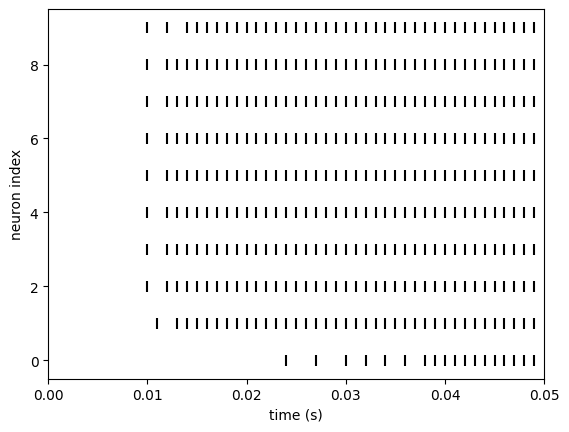

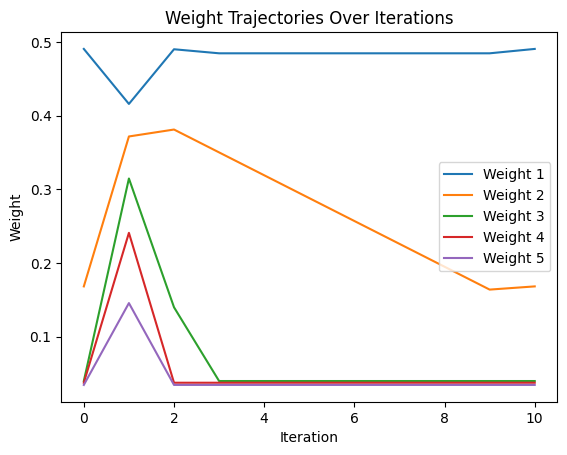

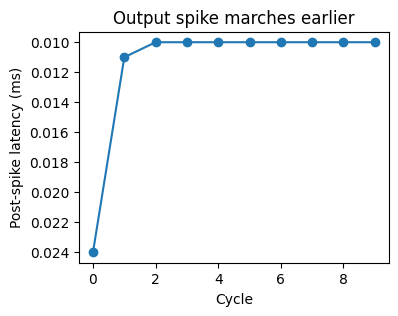

In [ ]:
#  Simulation & model parameters
dt = 1e-3  # simulation time step [s]
tau_m = 20e-3  # membrane time constant [s]
v_rest = -0.070  # resting potential [V]
v_reset = -0.060  # reset potential [V]
v_th = -0.054  # spike threshold [V]
tau_ex = 5e-3  # excitatory synaptic decay [s]
tau_in = 5e-3  # inhibitory synaptic decay [s]

g_max = 0.5  # max excitatory weight (dimensionless w.r.t. leak conductance)
g_in = 0.05  # fixed inhibitory weight per spike

# STDP constants
tau_plus = 20e-3
tau_minus = 20e-3
A_plus = 0.005  # fraction of g_max added per causal pair
A_minus = 1.05 * A_plus

# expeirment
latency_spikes = 2
T = 0.050  # 50 ms cycle
cycles = 10
N_exc = 5


def run_simple(exc_spike_trains, g, T):
    """Simulate the LIF neuron for T seconds.
    exc_spike_trains – list of numpy arrays with spike times for each excitatory synapse.
    Returns (postsynaptic spike times, final weights list)."""

    n_steps = int(T / dt)
    M = 0.0
    P = np.zeros(len(g))
    post_spk = []
    g_ex = 0
    v = v_rest

    for step in range(n_steps):
        t = step * dt

        # iterate through all neurons and check if they are firering
        for a, spks in enumerate(exc_spike_trains):
            if spks[0] <= t and spks.size:
                g_ex += g[a]
                P[a] += A_plus
                g[a] = max(g[a] + M * g_max, 0.0)
                np.delete(exc_spike_trains[a], 0)

        g_ex -= (dt / tau_ex) * g_ex

        M -= M / tau_minus * dt
        P -= P / tau_plus * dt

        dv = (v_rest - v - g_ex * v) / tau_m * dt
        v += dv

        if v >= v_th:
            post_spk.append(t)
            v = v_reset
            M -= A_minus
            g += P * g_max
            np.minimum(g, g_max, out=g)

    return np.array(post_spk), g


# -- run the experiment --
g = np.full(N_exc, 0.1 * g_max)  # small initial weights
g_history = [g.copy()]  # collect weights
post_spike_history = []  # collect output times

weight_traj = [g]
spikes_traj = []

print(f"initial weights: {g}")

for i in range(cycles):
    spikes, weights = run_simple(latency_spikes, g, T)

    spikes_traj.append(spikes)
    weight_traj.append(weights.copy())

print(f"final weights: {g}")

# plot spikes per cycle
plot_spikes(spikes_traj, T)

# plot of weight changes
plt.figure()
weight_traj_array = np.array(weight_traj)
for i in range(N_exc):
    plt.plot(weight_traj_array[:, i], label=f"Weight {i + 1}")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.title("Weight Trajectories Over Iterations")
plt.legend()
plt.show()


# plot the first spike of each cycle
plt.figure(figsize=(4, 3))
plt.plot([spikes[0] if len(spikes) > 0 else None for spikes in spikes_traj], marker="o")
plt.gca().invert_yaxis()  # earlier = up
plt.xlabel("Cycle")
plt.ylabel("Post-spike latency (ms)")
plt.title("Output spike marches earlier")
plt.show()

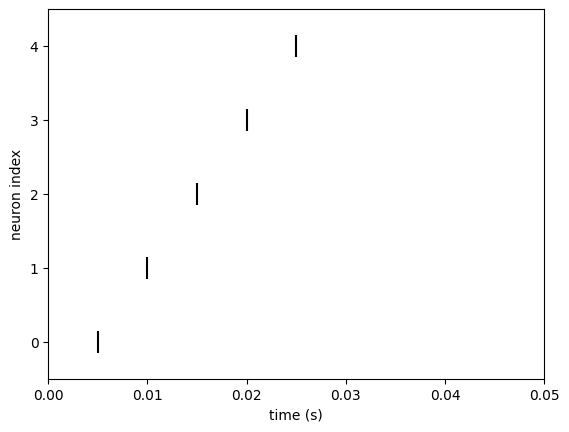

In [3]:
# input spike train
plot_spikes(latency_spikes, T)

## Task 2:
We are now going to implement the simulation experiment over different input rates.

1. Draw Poisson spikes (feel free to plot to check)
2. Update your simulation to include inhibitionas well as excitation. The simulation should start with all weights set to g_max.
3. Run your simulation for 1s and report the final STDP adapted weights. 

In [4]:
g_max = 0.15  # max excitatory weight (dimensionless w.r.t. leak conductance)
g_in = 0.5  # fixed inhibitory weight per spike


# Network size
N_exc = 250  # number of excitatory synapses (reduced for speed)
N_inh = 75  # number of inhibitory synapses

In [5]:
def poisson_spike_times(rate, T, rng=rng):
    n_spikes = rng.poisson(rate * T)
    return np.sort(rng.random(n_spikes) * T)


def run_sim(exc_spike_trains, inh_spike_trains, T, g_multiple=1.0):
    """Simulate the LIF neuron for T seconds.
    exc_spike_trains – list of numpy arrays with spike times for each excitatory synapse.
    inh_spike_trains – list of numpy arrays with spike times for each excitatory synapse..
    Returns (postsynaptic spike times, final weights list)."""

    n_exc = len(exc_spike_trains)
    g = np.full(n_exc, g_multiple * g_max)

    n_steps = int(T / dt)
    M = 0.0
    P = np.zeros(len(g))
    post_spk = []
    g_ex = 0.0
    g_inh = 0.0
    v = v_rest

    for step in tqdm(range(n_steps)):
        t = step * dt

        # iterate through all neurons and check if they are firering
        for a, spks in enumerate(exc_spike_trains):
            while spks.size and spks[0] <= t:
                g_ex += g[a]
                P[a] += A_plus
                g[a] = max(g[a] + M * g_max, 0.0)
                spks = spks[1:]  # delete first spike
                exc_spike_trains[a] = spks

        for a, i_spks in enumerate(inh_spike_trains):
            while i_spks.size and i_spks[0] <= t:
                g_inh += g_in
                i_spks = i_spks[1:]  # delete first pike
                inh_spike_trains[a] = i_spks

        # Process inhibitory spikes
        # for i_spks in inh_spike_trains:
        #     while i_spks.size and i_spks[0] <= t:
        #         g_inh += g_in
        #         i_spks = i_spks[1:]  # delete first spike

        # update weights
        g_ex -= (dt / tau_ex) * g_ex
        g_inh -= (dt / tau_in) * g_inh

        # update M and P
        M -= M / tau_minus * dt
        P -= P / tau_plus * dt


        # update voltage
        dv = (v_rest - v - g_ex * v + g_inh * (v_rest - v)) / tau_m * dt
        v += dv


        if v >= v_th:
            post_spk.append(t)
            v = v_reset
            M -= A_minus
            g += P * g_max
            np.minimum(g, g_max, out=g)

    return np.array(post_spk), g


100%|██████████| 200000/200000 [00:27<00:00, 7248.00it/s]


Input rate 10 Hz → output rate: 67.51 Hz


100%|██████████| 200000/200000 [00:25<00:00, 7759.15it/s]


Input rate 20 Hz → output rate: 39.62 Hz


100%|██████████| 200000/200000 [00:29<00:00, 6815.19it/s]


Input rate 40 Hz → output rate: 21.70 Hz


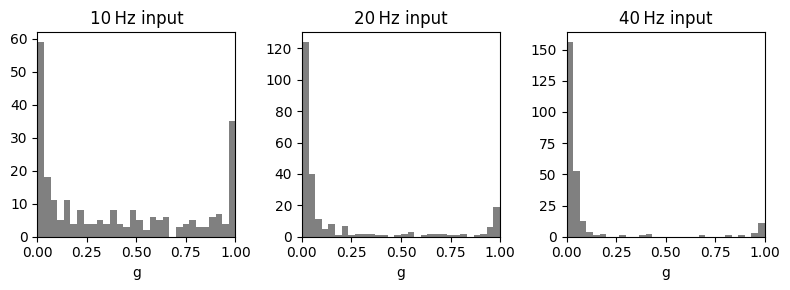

In [6]:
# Parameters of this expeirment.
T_sim = 200.0  # seconds per experiment (increase for better convergence)
rates = [10, 20, 40]  # Hz
inh_rate = 10  # Hz per inhibitory synapse

# run simulation for each rate
all_results = {}
for rate in rates:
    exc_trains = [poisson_spike_times(rate, T_sim) for _ in range(N_exc)]
    inh_trains = [poisson_spike_times(inh_rate, T_sim) for _ in range(N_inh)]
    post_spk, w_final = run_sim([np.copy(tr) for tr in exc_trains], [np.copy(tr) for tr in inh_trains], T_sim)
    all_results[rate] = (post_spk, w_final)
    print(f'Input rate {rate} Hz → output rate: {len(post_spk)/T_sim:.2f} Hz')

# plot weight distribution per rate
plt.figure(figsize=(8,3))
for i, rate in enumerate(rates):
    plt.subplot(1,3,i+1)
    plt.hist(np.divide(all_results[rate][1], g_max), bins=30, color='grey')
    plt.title(f'{rate} Hz input')
    plt.xlim(0, 1.0)
    plt.xlabel('g')
plt.tight_layout()
plt.show()

## Task 3: Rate coding

We will now check what happens if the rate of different input neurons is informative. Your first 50 input neurons are going to fire at 40Hz (Poisson), whereas remaining 200 input neurons are only going to fire at 5hz (Poisson). 

1. What is your expectation?
2. Run the experiment for 1s, report the results.
3. Check your expectation / intuition.


#### 1. Expectation
When we include neurons that fire at different rates, we would expect that after training higher rate neurons should have higher weights, just like in biology, where high stimulation of first pre- then post-synapse leads to LTP. The lower rate neurons on the other hand should have smaller weights in the end as we expect LTD to occur more frequently. This might be because if the neurons fire less frequently, the likelihood of pre- and post-synapse to fire in close sequence would be decreased and therefore cause LTD. However, as we  have seen in Task 2, the more frequent updates that high firing rate neurons get lead to more LTD. 

On average the fireing rate in thia experiment is 12. If having neurons with different firing rates leads to increased information we would expect the final weight distribution to look quite different to the 10Hz one from task 2 despite similar average firing rate. 



100%|██████████| 1000000/1000000 [02:13<00:00, 7483.34it/s]


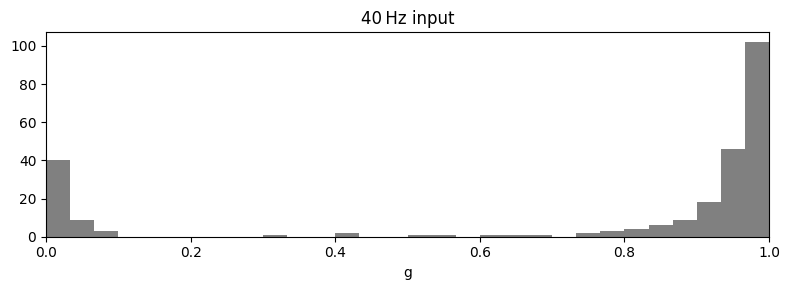

In [7]:
# --- Rate‑code experiment ---
T_sim = 1000.0
high_rate = 40  # Hz
low_rate = 5  # Hz1
n_high = 50
n_low = N_exc - n_high

exc_trains = [poisson_spike_times(high_rate, T_sim) for _ in range(n_high)] + [poisson_spike_times(low_rate, T_sim) for _ in range(n_low)]
inh_trains = [poisson_spike_times(inh_rate, T_sim) for _ in range(N_inh)]

post_spk, w_final = run_sim([np.copy(tr) for tr in exc_trains], [np.copy(tr) for tr in inh_trains], T_sim)

plt.figure(figsize=(8,3))
plt.hist(np.divide(w_final, g_max), bins=30, color='grey')
plt.title(f'{rate} Hz input')
plt.xlim(0, 1.0)
plt.xlabel('g')
plt.tight_layout()
plt.show()

#### Interpration

It seems like the high firing rate neurons have been surpressed, and thus have very low weights, while the low firing rate neurons are close to weights of 1.0. This is a classic bimodal distribution with nearly no middel ground. To be fair, we are not sure if the the low weight neurons are actually the high firing rate ones, except for the fact that the number of occurences is similar (~45 to 50).

This is more or less in line with the previous findings, that high firing rate neurons gets surpressed more, because of the more frequent weight updates and thus have lower weights in the end. Furthermore the distribution looks significantly different from the 10Hz one of the previous task. Both are bimodal, but this one is a lot heavier on the right side than on the left side. It is important to mention that this simulation ran for a longer time (1000 vs 200)
